<a href="https://colab.research.google.com/github/seunghee0518/AI_python/blob/main/EfficientNet_b0_sam_MVtecAD_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## trina/ test 나눠서 학습

In [1]:
'''
torch.hub : Pytorch Hub는 연구 재현성을 촉진하도록 설계된 사전 훈련 된 모델 저장소
nvidia_efficientnet_b4 사전 모델 가져옴
'''
# import torch
# model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
!pip install timm
import timm
model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=88)

In [ ]:
# from pprint import pprint
# model_names = timm.list_models(pretrained=True)
# pprint(model_names)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
## 학습 코드
import warnings
warnings.filterwarnings('ignore')

import torch
from glob import glob
from tqdm import tqdm
import cv2
#import timm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score
import gc
import pandas as pd
import numpy as np
import json
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from PIL import Image
# from efficientnet_pytorch import EfficientNet
# model_name = 'efficientnet-b0'  # b5

# image_size = EfficientNet.get_image_size(model_name)
# print(image_size)
# model = EfficientNet.from_pretrained(model_name, num_classes=88)

In [4]:
## 기본 설정
device = torch.device('cuda')
batch_size  = 32
random_seed = 1234
img_size = 224
random.seed(random_seed)
torch.manual_seed(random_seed)

## transforms 함수 정리
* transforms.ToPILImage() - csv 파일로 데이터셋을 받을 경우, PIL image로 바꿔준다.
* transforms.CenterCrop(size) - 가운데 부분을 size 크기로 자른다.
* transforms.Grayscale(num_output_channels=1) - grayscale로 변환한다.
* transforms.RandomAffine(degrees) - 랜덤으로 affine 변형을 한다.
* transforms.RandomCrop(size) -이미지를 랜덤으로 아무데나 잘라 size 크기로 출력한다.
* transforms.RandomResizedCrop(size) - 이미지 사이즈를 size로 변경한다
* transforms.Resize(size) - 이미지 사이즈를 size로 변경한다
* transforms.RandomRotation(degrees) 이미지를 랜덤으로 degrees 각도로 회전한다.
* transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)) - 이미지를 랜덤으로 변형한다.
* transforms.RandomVerticalFlip(p=0.5) - 이미지를 랜덤으로 수직으로 뒤집는다. p =0이면 뒤집지 않는다.
* transforms.RandomHorizontalFlip(p=0.5) - 이미지를 랜덤으로 수평으로 뒤집는다.
* transforms.ToTensor() - 이미지 데이터를 tensor로 바꿔준다.
* transforms.Normalize(mean, std, inplace=False) - 이미지를 정규화한다.

In [5]:
## 데이터 전처리 함수
# make dataset
#data_path = 'president/president_data'  # class 별 폴더로 나누어진 걸 가져와서 라벨도 달아준다
# train_dataset = datasets.ImageFolder(data_path,
#                                      transforms.Compose([
#                                      transforms.Resize((224, 224)),
#                                      transforms.RandomCrop(224),
#                                      transforms.RandomRotation(90, expand=True),
#                                      transforms.RandomVerticalFlip(),
#                                      transforms.RandomHorizontalFlip(),
#                                      transforms.ToTensor(), # 이미지 데이터를 tensor로 바꿔준다.
#                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])) # Normalize는 많은 이미지의 평균, 표준편차로 정함(보통 많이 하는 값이라고함)


### 이미지 전처리 함수 & 클래스
## 이미지  > 넘파이 배열로 변환
def img_load(path):
    img = cv2.imread(path)[:,:,::-1] # Return type:	numpy.ndarray / 기본적으로 BGR로 불러옴, RGB 변환함
    img = cv2.resize(img, (224, 224))
    return img

class Custom_dataset_1(Dataset): # 기본
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode = mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        img = transforms.ToTensor()(img) # PIL or ndarray -> tensor
        img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
        ## 레이블 > 원-핫 인코딩 하기 
        label = self.labels[idx]# (원핫인코딩 안할거면 해당 코드만 필요)
        return img, label

class Custom_dataset_2(Dataset): # 변형
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode = mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        if self.mode == 'train':
          img = Image.fromarray(img)
          #img = transforms.Resize((img_size, img_size))(img) # 처음 이미지 불러올때 resize 했으므로 생략
          #img = transforms.RandomCrop(img_size)(img)
          img = transforms.RandomRotation(90, expand=False)(img)
          img = transforms.RandomVerticalFlip()(img)
          img = transforms.RandomHorizontalFlip()(img)
          img = transforms.ToTensor()(img) # PIL or ndarray -> tensor
          img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
        if self.mode=='test':
          img = transforms.ToTensor()(img) # PIL or ndarray -> tensor
          img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
        ## 레이블
        label = self.labels[idx]# (원핫인코딩 안할거면 해당 코드만 필요)
        return img, label

class Custom_dataset_3(Dataset): # 기본이미지 + 변형이미지 (train 시 2배 증량됨)
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        if self.mode=='train':
          if idx < 4277: # 변경 없는 이미지
            img = self.img_paths[idx]
            img = transforms.ToTensor()(img) # PIL or ndarray -> tensor
            img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
            label = self.labels[idx]
            return img, label

          else : # 랜덤 변경된 이미지 추가됨 
            img = self.img_paths[idx]
            img = Image.fromarray(img)
            #img = transforms.Resize((img_size, img_size))(img) # 처음 이미지 불러올때 resize 했으므로 생략
            #img = transforms.RandomCrop(img_size)(img)
            img = transforms.RandomRotation(90, expand=False)(img)
            img = transforms.RandomVerticalFlip()(img)
            img = transforms.RandomHorizontalFlip()(img)
            img = transforms.ToTensor()(img) # PIL or ndarray -> tensor
            img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
            label = self.labels[idx]
            return img, label

        if self.mode=='test':
          img = self.img_paths[idx]
          img = transforms.ToTensor()(img)
          img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
          label = self.labels[idx]
          return img, label

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

In [6]:
### 이미지 로드 및 전처리
# 이미지 경로
train_png = sorted(glob('/content/drive/Othercomputers/내 MacBook Pro/open/train/*.png'))
train_imgs = [img_load(m) for m in tqdm(train_png)]

#train_imgs = np.load('/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/train_imgs_224.npy')
train_y = pd.read_csv("/content/drive/Othercomputers/내 MacBook Pro/open/train_df.csv")

train_labels = train_y["label"] # 레이블순서는 이미지 파일 순서대로임

label_unique = sorted(np.unique(train_labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))} # 오름차순으로 레이블별로 숫자 부여(0부터 시작)

train_labels = [label_unique[k] for k in train_labels]

# 커스텀 이미지 생성
train_dataset = Custom_dataset_1(np.array(train_imgs), np.array(train_labels), mode='train')
train_idx, vaild_idx = train_test_split(list(range(len(train_dataset))), stratify=train_labels, test_size=0.3, random_state=random_seed)

# ## 이미지 증량 시만 사용
# train_imgs = train_imgs + train_imgs
# train_labels = train_labels+train_labels

# train_dataset = Custom_dataset_3(np.array(train_imgs), np.array(train_labels), mode='train')

### 데이터셋 분리 > 층화추출 & 테스터 데이터 비율 : 0.3, 시드 : 1234, 셔플 = True(default)
train_idx, vaild_idx = train_test_split(list(range(len(train_dataset))), stratify=train_labels, test_size=0.3, random_state=random_seed)

datasets = {} # 데이터셋을 담을 딕셔너리
datasets['train'] = Subset(train_dataset, train_idx)
datasets['vaild']  = Subset(train_dataset, vaild_idx)

## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                                  batch_size=batch_size, shuffle=True,
                                                  num_workers=0)
dataloaders['vaild']  = torch.utils.data.DataLoader(datasets['vaild'],
                                                    batch_size=batch_size, shuffle=False,
                                                    num_workers=0)
'''
데이터 변형 코드를 추가한 후 아래 오류코드가 나와
Caught TypeError in DataLoader worker process 0
DataLoader > num_workers 를 4 -> 0 로 낮춤
'''

batch_num['train'], batch_num['vaild'] = len(dataloaders['train']), len(dataloaders['vaild'])
print('batch_size : %d,  train/vaild(데이터셋개수/배치사이즈) : %d / %d' % (batch_size, batch_num['train'],batch_num['vaild']))

100%|██████████| 4277/4277 [02:10<00:00, 32.84it/s]


batch_size : 32,  train/vaild(데이터셋개수/배치사이즈) : 94 / 41


In [7]:
# 참고 블로그 : https://keep-steady.tistory.com/35
import gc
gc.collect()
torch.cuda.empty_cache()

### f1 스코어 함수 
def score_function(real, pred): # 라이브러리 > sklearn.metrics 
    score = f1_score(real, pred, average="macro")
    return score

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    #train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    train_loss, train_acc, valid_loss, valid_acc, train_f1, valid_f1 = [], [], [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))# - 1))
        print('-' * 10)
        train_pred=[]# 이거 추가 : f1스코어 계산
        train_y=[]#이거 추가

        # Each epoch has a training and validation phase
        for phase in ['train', 'vaild']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) # device = torch.device('cuda')
                labels = labels.to(device) # device = torch.device('cuda')

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # # backward + optimize only if in training phase
                    # if phase == 'train':
                    #     loss.backward()
                    #     optimizer.step()

                    # backward + optimize only if in training phase + sam
                    if phase == 'train':
                        loss.backward()
                        optimizer.first_step(zero_grad=True)
                        criterion(model(inputs), labels).backward()
                        optimizer.second_step(zero_grad=True)


                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)

                train_pred += preds.detach().cpu().numpy().tolist() #이거 추가
                train_y += labels.detach().cpu().data.numpy().tolist() #이거 추가

            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            f1 = score_function(train_y,  train_pred) # score_function or f1_score

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                train_f1.append(f1)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
                valid_f1.append(f1)

            print('{} Loss: {:.5f} Acc: {:.5f} macro-f1: {:.5f}'.format(phase, epoch_loss, epoch_acc, f1))
           
            # deep copy the model(최적모델 저장)
            if phase == 'vaild' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))
        # 한 에포크마다 실행 시간 출력하기(누적 시간으로 출력됨)
        time_elapsed = time.time() - since
        print('each epochs training time : {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('\n')

        # 한 에포크마다 필요없는 메모리 지우기 : 지우기 효과는 아직 확인 못해봄
        try:      
          gc.collect() # cpu 비움
          torch.cuda.empty_cache() # gpu 비움
        except:
          pass
          
    ## 학습 마무리 후
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    '''
    한 에포크 마다 저장된 최적의 모델 가중치로 조정 후 다음 에포크가 돌아감
    '''
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'president_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc, train_f1, valid_f1

# 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# optimizer_ft = optim.SGD(model.parameters(), 
#                          lr = 0.05,
#                          momentum=0.9,
#                          weight_decay=1e-4)

# lmbda = lambda epoch: 0.98739
# exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

## 변경된 옵티마이저
base_optimizer = torch.optim.SGD
optimizer_ft = SAM(model.parameters(), base_optimizer, lr=0.001, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft,
                                                step_size = 5,
                                                gamma = 0.75)



# 사전학습된 가중치와 모델을 가져와 데이터셋으로 추가 모델 학습
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc, train_f1, valid_f1 = train_model(model, criterion, optimizer_ft, lr_scheduler, num_epochs=100)

Epoch 0/100
----------
train Loss: 4.16823 Acc: 18.81056 macro-f1: 0.04672
vaild Loss: 3.70072 Acc: 60.74766 macro-f1: 0.07023
==> best model saved - 0 / 60.7
each epochs training time : 1m 27s


Epoch 1/100
----------
train Loss: 3.16580 Acc: 76.54527 macro-f1: 0.13826
vaild Loss: 2.57698 Acc: 83.25545 macro-f1: 0.14092
==> best model saved - 1 / 83.3
each epochs training time : 2m 56s


Epoch 2/100
----------
train Loss: 1.89886 Acc: 83.22753 macro-f1: 0.14436
vaild Loss: 1.37255 Acc: 83.41121 macro-f1: 0.14447
==> best model saved - 2 / 83.4
each epochs training time : 4m 27s


Epoch 3/100
----------
train Loss: 1.32399 Acc: 83.76211 macro-f1: 0.14903
vaild Loss: 1.20302 Acc: 84.73520 macro-f1: 0.15180
==> best model saved - 3 / 84.7
each epochs training time : 5m 60s


Epoch 4/100
----------
train Loss: 1.19166 Acc: 84.73104 macro-f1: 0.15569
vaild Loss: 1.11746 Acc: 84.81308 macro-f1: 0.15586
==> best model saved - 4 / 84.8
each epochs training time : 7m 32s


Epoch 5/100
--------

best model : 95 - 86 / 0.6


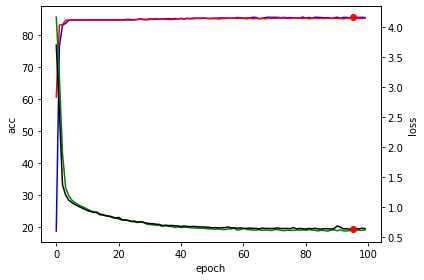

In [8]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

## 모델 추론

In [9]:
## 모델을 평가 모드로 변경하고 test 데이터 분류
test_png = sorted(glob('/content/drive/Othercomputers/내 MacBook Pro/open/test/*.png'))
test_imgs = [img_load(n) for n in tqdm(test_png)]
test_dataset = Custom_dataset_3(np.array(test_imgs), np.array(["tmp"]*len(test_imgs)), mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

model.eval()
f_pred = []

with torch.no_grad():
    for batch in (test_loader):
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

100%|██████████| 2154/2154 [01:04<00:00, 33.40it/s]


In [10]:
## 숫자로된 레이블을 문자열 레이블로 변경
label_decoder = {value:key for key, value in label_unique.items()}
f_result = [label_decoder[result] for result in f_pred]

In [11]:
from datetime import datetime as dt 
today = dt.today().strftime('%Y-%m-%d')
version = f'efficientNet_b4_sam_by_timm_data_ver1_{today}'
submission = pd.read_csv(f"/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/sample_submission.csv")

## 시각적 확인을 위해 문자열 레이블로 이루어진 된 label 필드 생성
submission["label"] = f_result
display(submission)
submission.to_csv(f"/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/sample_submission_{version}.csv", index = False)

,index,label
0,0,tile-good
1,1,grid-good
2,2,transistor-good
3,3,tile-good
4,4,tile-good
...,...,...
2149,2149,tile-good
2150,2150,screw-good
2151,2151,grid-good
2152,2152,cable-good


In [12]:
# 모델 저장
model_version = f'efficientNet_b4_sam_data_ver1_{today}'
torch.save(model.state_dict(), f'/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/{model_version}.pt')